In [9]:
from datasets import load_dataset
ds = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks_revised")

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

What is this dataset?

This is a DNA sequence dataset that has been classified into many types: enhancer, promoter, specific histone marks under the label "task". This was curated by InstaDeep, for their Nucleotide transformers paper, from sources like ENCODE etc.
The DNA sequence for each task(type) varies in length. For classification into enhancers, the DNA sequence length is 1kb, but for promoters it is 300bp. 


What do we want to do?

We want to analyse the DNA sequences using the ML models : Linear classification / Decision Trees (Random Forest / XGBoost) and classify them as a "yes/no" into selected categories. I have chosen to work with TATA-less promoters: these are a class of promoters that lack the TATA box recognised by the RNA polymerase, and I would like to see if basic ML models can derive any patterns in the DNA to classifiy them as promoters or not promoters.


What is required?

The ML models cannot read the DNA sequence: therefore we must convert them into readable data for the model. We need to select parameters/categories from which we can describe this sequence, input them into the model and see if the model can predict 


In [ ]:
# Unique tasks in the train split
print(set(ds['train']['task']))

# Number of examples per task
from collections import Counter
print("How many examples per task in the train split?")
print(Counter(ds['train']['task']))

{'enhancers', 'H4K20me1', 'H3K9ac', 'enhancers_types', 'splice_sites_all', 'splice_sites_donors', 'H3K4me3', 'promoter_all', 'H3K36me3', 'H3K27ac', 'promoter_no_tata', 'H3K9me3', 'splice_sites_acceptors', 'H3K4me2', 'promoter_tata', 'H3K4me1', 'H3K27me3', 'H2AFZ'}
How many examples per task in the train split?
Counter({'H2AFZ': 30000, 'H3K27ac': 30000, 'H3K27me3': 30000, 'H3K36me3': 30000, 'H3K4me1': 30000, 'H3K4me2': 30000, 'H4K20me1': 30000, 'enhancers': 30000, 'enhancers_types': 30000, 'promoter_all': 30000, 'promoter_no_tata': 30000, 'splice_sites_acceptors': 30000, 'splice_sites_all': 30000, 'splice_sites_donors': 30000, 'H3K9me3': 27438, 'H3K9ac': 23274, 'H3K4me3': 17468, 'promoter_tata': 5062})


In [ ]:
# Filter the dataset to get promoter_no_tata data only
promoters_ds = ds.filter(lambda example: example["task"] == "promoter_no_tata")

We need to create categories from the DNA sequence. What can be possible features of the DNA that can be used to classify between promoters and not promoters?

1) GC content of the promoter
2) Presence of specific 5mers (512 features/kmers, seq and rc counted together)

In [1]:
import itertools
import pandas as pd
import numpy as np

In [2]:
# motif info database
complement = str.maketrans('ATGC', 'TACG')
b = ['A', 'T', 'G', 'C']
mers5 = [''.join(p) for p in itertools.product(b, repeat=5)]
rc_mers5 = [''] * int(len(mers5)/2)
for i, s in enumerate(mers5):
    rc_mers5[i] = s[::-1].translate(complement)
    if rc_mers5[i] in mers5:
        mers5.remove(rc_mers5[i])
mer5_list = np.column_stack((mers5, rc_mers5))

In [3]:
def compute_5mer_counts(sequence):
    motif_counts = np.zeros(len(mer5_list), dtype=int)
    for i in range(len(sequence) - 4):
        kmer = sequence[i:i+5]
        idx = np.where(mer5_list == kmer)[0].item()
        motif_counts[idx] += 1
    return motif_counts

In [4]:
def compute_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    return gc_count / len(sequence)

In [110]:
# for a given dataset convert DNA sequence to motif features and GC content, and scale them
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def makeXY(ds):
    n_samples = len(ds)
    n_features = 512 + 1  # 512 5-mer counts + 1 GC content
    X = np.zeros((n_samples, n_features))  # shape: (samples, features)
    y = []

    for i,currSeq in enumerate(ds):
        seq = currSeq['sequence']
        label = currSeq['label']
        X[i,:] = np.concatenate((compute_5mer_counts(seq), [compute_gc_content(seq)]))
        y.append(label)
    
    X_scaled = scaler.fit_transform(X)
    feature_names = [f'{mer}' for mer in mer5_list[:,0]] + ['gc_content']
    return X_scaled, np.array(y), feature_names

Now do Exploratory Data Analysis on the training dataset to see if we have any catchy features differentiating promoters vs non-promoters

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

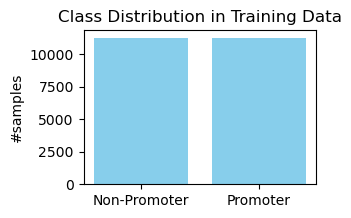

In [31]:
# how many promoters vs non-promoters in training data?
unique, counts = np.unique(y_train, return_counts=True)

categories = ['Non-Promoter', 'Promoter']
plt.figure(figsize=(3,2))
plt.bar(categories, counts, color='skyblue')  # vertical bar plot
plt.ylabel('#samples')
plt.title('Class Distribution in Training Data')
plt.show()


In [111]:
# no need to split train into train and val as we will use cross-validation


X_train, y_train, feature_names = makeXY(promoters_ds['train'])
X_test, y_test, _ = makeXY(promoters_ds['test'])


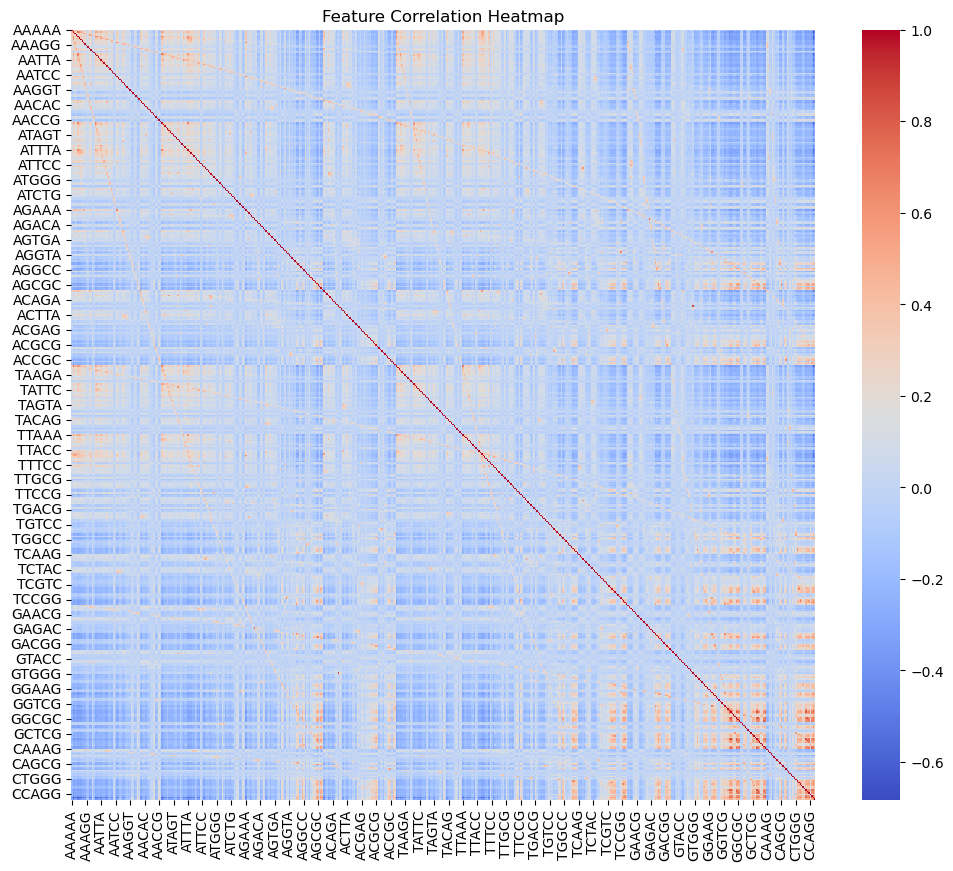

In [112]:
# convert X_train, y_train to a df for EDA

df_train = pd.DataFrame(X_train, columns=feature_names)
df_train['label'] = y_train

corrMatrix_all= df_train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corrMatrix_all, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


given that there are so many samples and features, it is hard to say anything from here. we can just derive that there are some patterns: given that the whole plot doesn't look like noise. this means that some of our input features could have strong correlations (across promoters and non-promoters)

/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.02, 'Non-Promoter Samples Correlation')

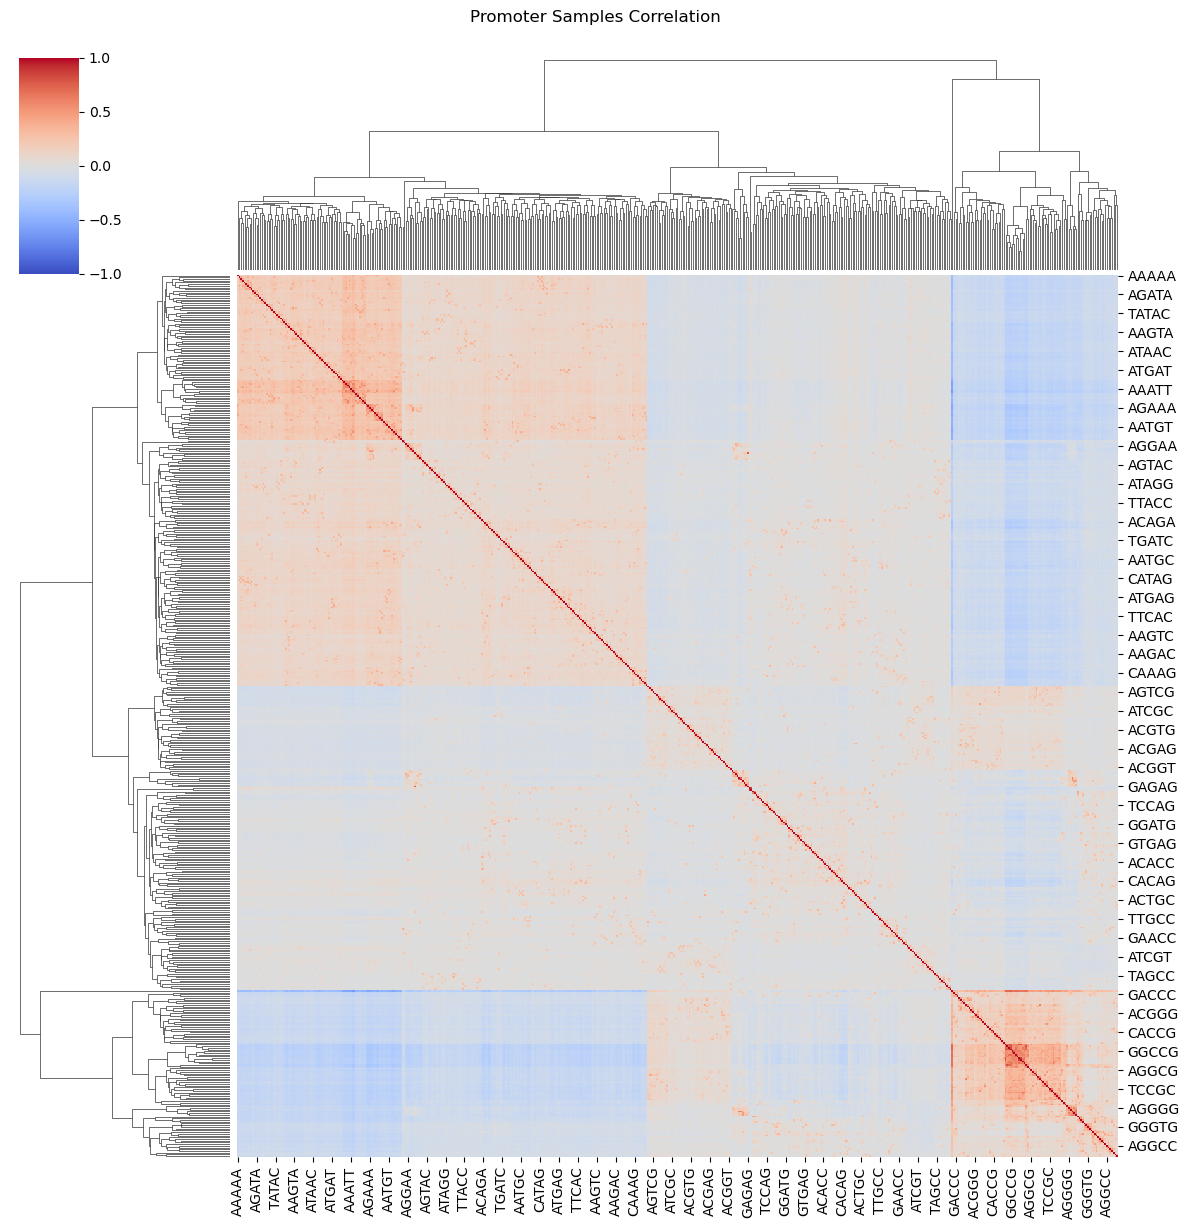

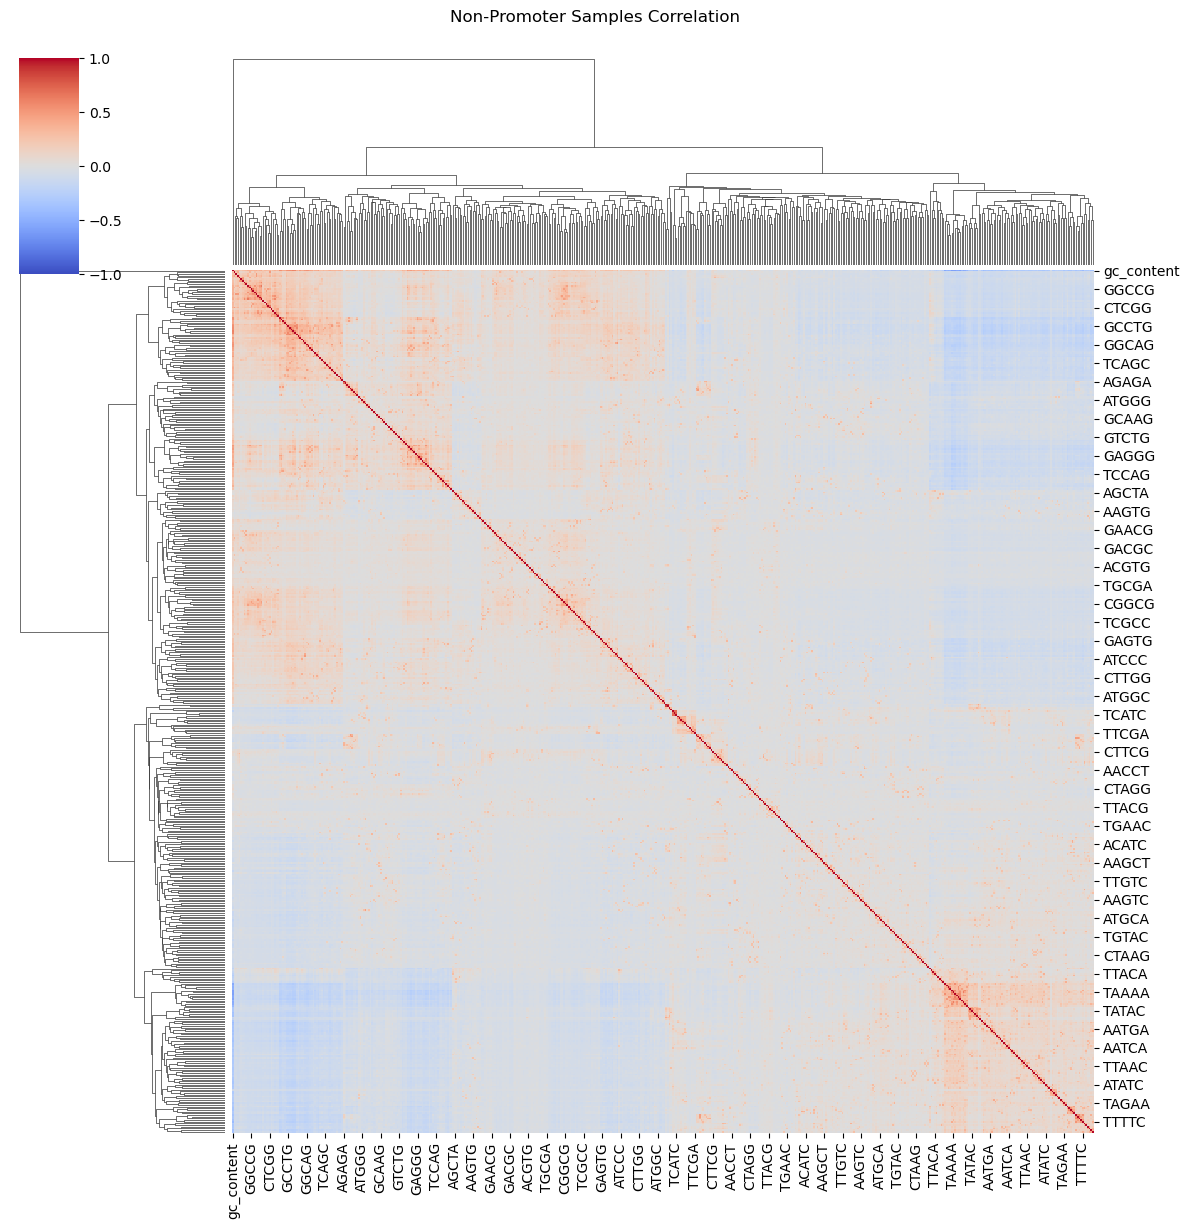

In [ ]:
# what are the correlations within the promoters and non-promoters separately? do we see better clustering for either class?

promoter_idx = df_train['label'] == 1
non_promoter_idx = df_train['label'] == 0

# Promoter clustermap
g1 = sns.clustermap(
    df_train.loc[promoter_idx, feature_names].corr(),
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.0,
    figsize=(12, 12),
    method='average',
    metric='euclidean'
)
g1.fig.suptitle('Promoter Samples Correlation', y=1.02)  # slight bump for spacing

# Non-Promoter clustermap
g2 = sns.clustermap(
    df_train.loc[non_promoter_idx, feature_names].corr(),
    vmin=-1, vmax=1,
    cmap='coolwarm',
    linewidths=0.0,
    figsize=(12, 12),
    method='average',
    metric='euclidean'
)
g2.fig.suptitle('Non-Promoter Samples Correlation', y=1.02)


We can see that the clustering of features is stronger in promoters than non-promoters.

However from this massive plot we can't tell much about the actual features causing the clusters.

What can this mean?

1) Randomly, there is a correlation among the features that we describe the DNA sequence by. This is depticed by the non-promoter correlation clustering plot.
2) There is a higher than random correlation among the features describing the promoter DNA sequence.
3) This indicates that there are features that are together, more likely to, or less likely to be in the promoter DNA sequence. 


What can we test next?
1) What features correlate most with each other, by random chance (or biological design, just not based on promoter vs non-promoter)?
2) What are the features that correlate most to being a promoter?
3) what are the least number of features by which, using a regular visualisable plot, we can tell apart promoters and non-promoters?

In [38]:
# Find the maximum correlation (excluding diagonal)

corr_no_diag = corrMatrix_all.copy()
np.fill_diagonal(corr_no_diag.values, np.nan)

max_corr = corr_no_diag.max().max()
rows, cols = np.where(corr_no_diag == max_corr)
for row, col in zip(rows, cols):
    print(f"Features: {corr_no_diag.index[row]} and {corr_no_diag.columns[col]} with correlation {max_corr}")

Features: GCGGC and CGGCG with correlation 0.8967185926203757
Features: CGGCG and GCGGC with correlation 0.8967185926203757


Should we keep these features that have such high correlation? To keep the ML basic and simple, lets not exclude these

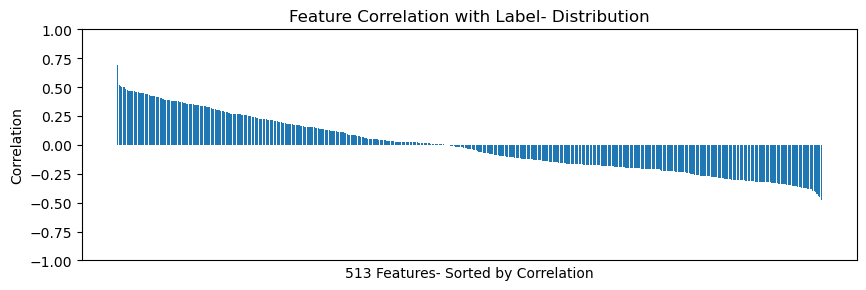

In [55]:
# which features have highest corr with the label?
corr_with_label = corrMatrix_all['label'].drop('label')
sortedfeatures = corr_with_label.sort_values(ascending=False)

plt.figure(figsize=(10,3))
plt.bar(sortedfeatures.index, sortedfeatures.values)
plt.title('Feature Correlation with Label- Distribution')
plt.ylabel('Correlation')
plt.ylim([-1,1])

plt.xticks([])
plt.xlabel('513 Features- Sorted by Correlation')
plt.show()

Roughly half the features are positively and half are negatively correlated to being a promoter. Lets try other metrics, like the mutual information score

/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


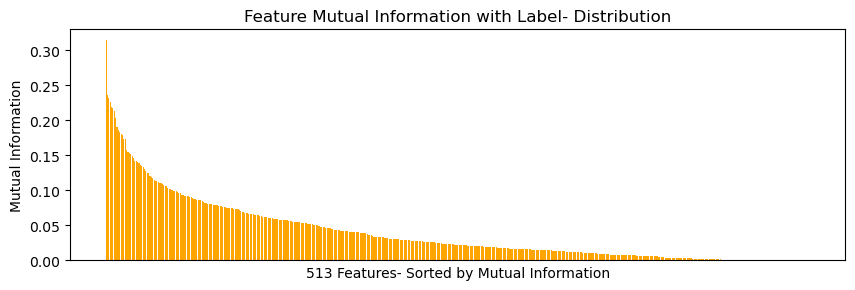

In [67]:
# mutual information of each feature with the label
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train, discrete_features=True, random_state=1)
mi_series = pd.Series(mi, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10,3))
plt.bar(mi_series.index, mi_series.values, color='orange')
plt.title('Feature Mutual Information with Label- Distribution')
plt.ylabel('Mutual Information')
plt.xticks([])
plt.xlabel('513 Features- Sorted by Mutual Information')
plt.show()

The MI distribution looks similar to the correlation, as expected.

How do these featurees coorelate with respect to each other? Lets see how many Principal componenets are required to descrive all the features?

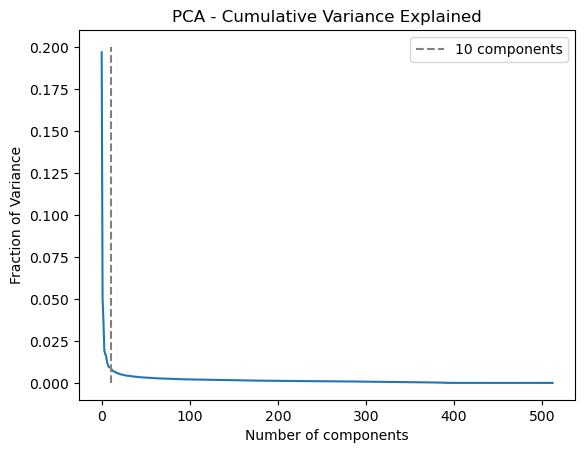

In [81]:
from sklearn.decomposition import PCA

pca = PCA().fit(df_train[feature_names])
plt.plot((pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Fraction of Variance")
plt.title("PCA - Cumulative Variance Explained")
plt.plot( np.full(100, 10), np.linspace(0, 0.2, 100), linestyle='dashed', color='grey', label='10 components')
plt.legend()
plt.show()

The dotted line deptics the top 10 PCs: this tells us that all the features can simply be described with 10 PCs: they are highly dependent on each other. But as said earlier, let us keep all the features to be simple for our standard ML model.

Can the top 2 PCs tell apart promoter vs non-promoter?

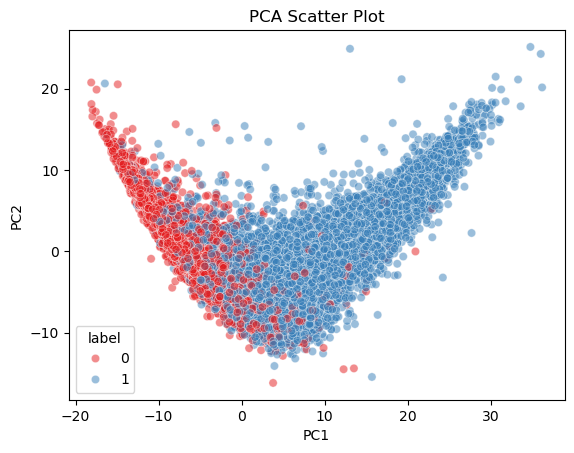

In [ ]:
# PCA scatter plot of first 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)  

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['label'] = y_train

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', palette='Set1', alpha=0.5)
plt.title('PCA Scatter Plot')
plt.show()


Yes, it looks like the top 2 PCs can tell apart promoter and non-promoter. But can we say the same about just the most correlated and anticorrelated feature? Or the top 2 MIs?

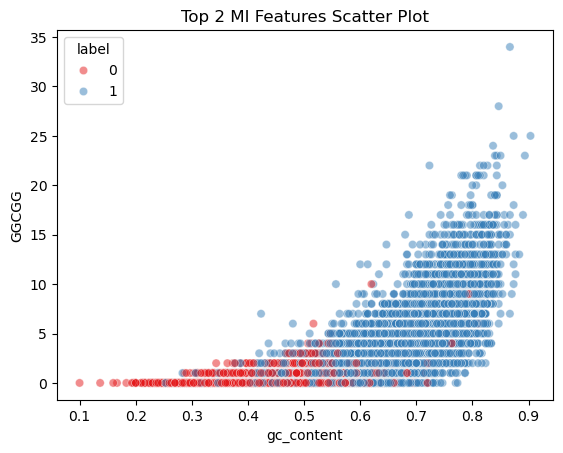

In [ ]:
# top 2 MIs vs promoter/non-promoter

df_top2mi = df_train[[mi_series.index[0], mi_series.index[1], 'label']]
sns.scatterplot(data=df_top2mi, x=mi_series.index[0], y=mi_series.index[1], hue='label', palette='Set1', alpha=0.5)
plt.title('Top 2 MI Features Scatter Plot')
plt.show()

Maybe well, but not as well as the PCs. This is because GC content and GGCGG themselves are highly correlated. Lets check out top correlated and anticorrelated features.

Most correlated feature: gc_content with corr: 0.6944983384681663
Most anticorrelated feature: AAAAT with corr: -0.4797810286826011


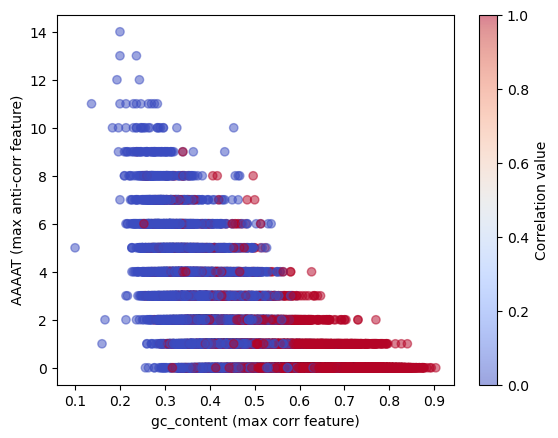

In [109]:

max_feat = sortedfeatures.idxmax()  # feature with highest correlation
min_feat = sortedfeatures.idxmin()  # feature with lowest correlation

print("Most correlated feature:", max_feat, "with corr:", sortedfeatures[max_feat])
print("Most anticorrelated feature:", min_feat, "with corr:", sortedfeatures[min_feat])
# Scatter plot
plt.scatter(df_train[max_feat], df_train[min_feat], c=df_train['label'], cmap='coolwarm', alpha=0.5)
plt.xlabel(f"{max_feat} (max corr feature)")
plt.ylabel(f"{min_feat} (max anti-corr feature)")
plt.colorbar(label='Correlation value')
plt.show()



Looks similar to the MI: the most correlated and anticorrelated are anticorrelated themselves. As all these features are so highly dependent on each other- we will get only this from the EDA. Lets just take them all and try different models.

What models to try?
1) Linear classifier: try different c: [0.001, 0.01, 0.1, 1, 10, 100]
2) Decision Tree:
3) Random Forest
4) XGBoost


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, f1_score, accuracy_score

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'negRMSE' : 'neg_mean_squared_error' #we need to do this because GridSearchCV always tries to maximize the metric, and RMSE needs to be minimized
}

model = LogisticRegression(
    penalty='l2',        
    solver='liblinear',  
    max_iter=1000,
    random_state=42
)

# tune C:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,                
    scoring=scoring,
    refit='roc_auc', #pick best model based on ROC AUC
)

grid.fit(X_train, y_train)

print("Best C:", grid.best_params_)
print("Best model (based on roc_auc):", grid.best_score_)

# access all metrics for each C
cv_results_regression = pd.DataFrame(grid.cv_results_)


Best C: {'C': 0.001}
Best model (based on roc_auc): 0.931434122549551


In [ ]:
cv_results_regression.T

,0,1,2,3,4,5,6
mean_fit_time,0.610322,0.961298,1.828917,3.650799,7.518429,11.473196,13.582258
std_fit_time,0.030812,0.026712,0.021745,0.335073,0.814015,0.874603,0.609502
mean_score_time,0.006588,0.006396,0.006284,0.006275,0.005791,0.006296,0.006758
std_score_time,0.001112,0.000643,0.000426,0.000701,0.000143,0.000621,0.001266
param_C,0.0001,0.001,0.01,0.1,1.0,10.0,100.0
params,{'C': 0.0001},{'C': 0.001},{'C': 0.01},{'C': 0.1},{'C': 1},{'C': 10},{'C': 100}
split0_test_accuracy,0.852167,0.858167,0.856833,0.855,0.854167,0.854,0.854333
split1_test_accuracy,0.860667,0.861667,0.861,0.860333,0.861,0.860333,0.859667
split2_test_accuracy,0.855667,0.858833,0.856333,0.855667,0.853833,0.853833,0.854167
split3_test_accuracy,0.861,0.861333,0.857333,0.856667,0.8585,0.858167,0.858667


In [126]:
best_model_regression = grid.best_estimator_

y_pred = best_model_regression.predict(X_test)
y_pred_proba = best_model_regression.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Test F1 Score:", f1_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred))

Test Accuracy: 0.8556851311953353
Test ROC AUC: 0.9365782964581084
Test F1 Score: 0.8493150684931506
Test RMSE: 0.14431486880466474


Ok- so we have the best possible regression model: with parameters:

Best C: {'C': 0.001}

Best model (based on roc_auc): 0.931


Test Accuracy: 0.855

Test ROC AUC: 0.936

Test F1 Score: 0.849

Test RMSE: 0.144


Let us try Decision Tree next

In [127]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)

param_grid_tree = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

grid_tree = GridSearchCV(
    estimator=tree,
    param_grid=param_grid_tree,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)
print("Best C:", grid_tree.best_params_)
print("Best model (based on roc_auc):", grid_tree.best_score_)

# access all metrics for each C
cv_results_tree = pd.DataFrame(grid_tree.cv_results_)

/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11

Best C: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best model (based on roc_auc): 0.904033284948062


In [129]:
best_model_tree = grid_tree.best_estimator_

y_pred = best_model_tree.predict(X_test)
y_pred_proba = best_model_tree.predict_proba(X_test)[:, 1]

print("Tree Test Accuracy:", accuracy_score(y_test, y_pred))
print("Tree Test ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Tree Test F1 Score:", f1_score(y_test, y_pred))
print("Tree Test RMSE:", mean_squared_error(y_test, y_pred))

cv_results_tree

Tree Test Accuracy: 0.8236151603498543
Tree Test ROC AUC: 0.9127276899931152
Tree Test F1 Score: 0.8109375
Tree Test RMSE: 0.17638483965014579


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.651348,0.038962,0.094433,0.009055,3,sqrt,1,2,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.850622,0.852599,0.848394,0.845023,0.851349,0.849597,0.002665,70
1,0.457697,0.224778,0.058844,0.039987,3,sqrt,1,5,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.850622,0.852599,0.848394,0.845023,0.851349,0.849597,0.002665,70
2,0.188886,0.035533,0.010873,0.002689,3,sqrt,1,10,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.850622,0.852599,0.848394,0.845023,0.851349,0.849597,0.002665,70
3,0.153700,0.009649,0.006940,0.003009,3,sqrt,2,2,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.850622,0.852599,0.848394,0.845023,0.851349,0.849597,0.002665,70
4,0.146055,0.021272,0.009191,0.004345,3,sqrt,2,5,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.850622,0.852599,0.848394,0.845023,0.851349,0.849597,0.002665,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,4.946976,0.198761,0.014907,0.004267,None,None,2,5,"{'max_depth': None, 'max_features': None, 'min...",0.805050,0.806168,0.812022,0.807486,0.811280,0.808401,0.002773,105
131,5.089164,0.229898,0.012837,0.006607,None,None,2,10,"{'max_depth': None, 'max_features': None, 'min...",0.824556,0.822284,0.825915,0.823561,0.822447,0.823753,0.001358,93
132,4.497273,0.539084,0.011405,0.006215,None,None,5,2,"{'max_depth': None, 'max_features': None, 'min...",0.837613,0.840918,0.839378,0.837161,0.841011,0.839216,0.001608,85
133,4.383260,0.289705,0.011740,0.005272,None,None,5,5,"{'max_depth': None, 'max_features': None, 'min...",0.837613,0.840918,0.839378,0.837161,0.841011,0.839216,0.001608,85


For a basic tree the best parameters are:

Best C: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

Best model (based on roc_auc): 0.904033284948062

Tree Test Accuracy: 0.823

Tree Test ROC AUC: 0.912

Tree Test F1 Score: 0.810

Tree Test RMSE: 0.176


This is still not as good as the regression.

Try Random forest next

In [132]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_grid_forest = { #selected params based on prior tuning on the tree
    'n_estimators': [10, 50, 100],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [5],
    'max_features': [None]
}

grid_forest = GridSearchCV(
    estimator=forest,
    param_grid=param_grid_forest,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_forest.fit(X_train, y_train)
print("Best params:", grid_forest.best_params_)
print("Best model (based on roc_auc):", grid_forest.best_score_)

# access all metrics for each parameter combination
cv_results_forest = pd.DataFrame(grid_forest.cv_results_)

/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11

Best params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best model (based on roc_auc): 0.9154113829535696


In [133]:
best_model_forest = grid_forest.best_estimator_

y_pred = best_model_forest.predict(X_test)
y_pred_proba = best_model_forest.predict_proba(X_test)[:, 1]

print("Forest Test Accuracy:", accuracy_score(y_test, y_pred))
print("Forest Test ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Forest Test F1 Score:", f1_score(y_test, y_pred))
print("Forest Test RMSE:", mean_squared_error(y_test, y_pred))

cv_results_forest

Forest Test Accuracy: 0.8345481049562682
Forest Test ROC AUC: 0.9229423964504586
Forest Test F1 Score: 0.8230709275136399
Forest Test RMSE: 0.16545189504373178


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.355858,0.117851,0.046808,0.009345,5,None,5,2,10,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.909441,0.914957,0.911739,0.914860,0.920886,0.914377,0.003854,3
1,45.345224,0.290375,0.063314,0.008027,5,None,5,2,50,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.910099,0.916251,0.912080,0.915735,0.922751,0.915383,0.004336,2
2,58.985740,12.417174,0.086057,0.034704,5,None,5,2,100,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.909628,0.916441,0.912350,0.915465,0.923173,0.915411,0.004564,1


The forest has performed better than the tree: as expected. I only gave limited parameters to test as I have limited computational power. From the given parameters, this was selected as the best model:

Best params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}

Best model (based on roc_auc): 0.915

And this model performs as:

Forest Test Accuracy: 0.834

Forest Test ROC AUC: 0.922

Forest Test F1 Score: 0.823

Forest Test RMSE: 0.165

Note: the test ROC is higher: this is ok because the "best ROC score" is actually the average across all the CVs, it is possible that this average is slightly lower than the test. 

In [134]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

param_grid_xgb = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
}

grid_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)
print("Best params:", grid_xgb.best_params_)
print("Best model (based on roc_auc):", grid_xgb.best_score_)

best_model_xgb = grid_xgb.best_estimator_

y_pred = best_model_xgb.predict(X_test)
y_pred_proba = best_model_xgb.predict_proba(X_test)[:, 1]

print("XGB Test Accuracy:", accuracy_score(y_test, y_pred))
print("XGB Test ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("XGB Test F1 Score:", f1_score(y_test, y_pred))
print("XGB Test RMSE:", mean_squared_error(y_test, y_pred))

cv_results_xgb = pd.DataFrame(grid_xgb.cv_results_)

/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Applications/miniforge3/envs/ml-zoomcamp/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11

Best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Best model (based on roc_auc): 0.9320168013632024
XGB Test Accuracy: 0.8418367346938775
XGB Test ROC AUC: 0.9349590731752926
XGB Test F1 Score: 0.8265387689848122
XGB Test RMSE: 0.15816326530612246


For the specified parameters in XGBoost, we get the best model to be:
Best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}

Best model (based on roc_auc): 0.932

And it performs like this on the test data:

XGB Test Accuracy: 0.841

XGB Test ROC AUC: 0.934

XGB Test F1 Score: 0.826

XGB Test RMSE: 0.158

From all the tested models: we can compare the test scores to select which of them is the best. For the scope of the parameters that we have tested here, it looks like regression based model has performed the best.

/var/folders/l8/19tfssl57w72c3vgx796cmb80000gp/T/ipykernel_19861/3905572842.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test ROC AUC', data=df_testScores, palette='viridis')


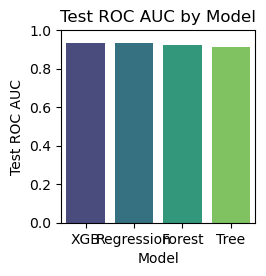

In [138]:
import pandas as pd

testScores = [
    {
        'Model': 'XGB',
        'Test Accuracy': 0.841,
        'Test ROC AUC': 0.934,
        'Test F1 Score': 0.826,
        'Test RMSE': 0.158
    },
    {
        'Model': 'Regression',
        'Test Accuracy': 0.855,
        'Test ROC AUC': 0.936,
        'Test F1 Score': 0.849,
        'Test RMSE': 0.144
    },
    {
        'Model': 'Forest',
        'Test Accuracy': round(0.8345481049562682, 3),
        'Test ROC AUC': 0.922,
        'Test F1 Score': 0.823,
        'Test RMSE': round(0.16545189504373178, 3)
    },
    {
        'Model': 'Tree',
        'Test Accuracy': round(0.8236151603498543, 3),
        'Test ROC AUC': round(0.9127276899931152, 3),
        'Test F1 Score': 0.810,
        'Test RMSE': round(0.17638483965014579, 3)
    }
]

# Convert to DataFrame
df_testScores = pd.DataFrame(testScores)

df_testScores 
plt.figure(figsize=(2.5,2.5))
sns.barplot(x='Model', y='Test ROC AUC', data=df_testScores, palette='viridis')
plt.title('Test ROC AUC by Model')
plt.ylim(0, 1)
plt.show()

We can see that all 4 tested models perform similarly, but if I have to pick one, I will choose to save the regression one as my main model. 

In [139]:
import joblib

# Suppose you have trained models
xgb_model = grid_xgb.best_estimator_   
forest_model = grid_forest.best_estimator_
tree_model = grid_tree.best_estimator_ 
regression_model = grid.best_estimator_

# Save models to files
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(forest_model, "forest_model.pkl")
joblib.dump(tree_model, "tree_model.pkl")
joblib.dump(regression_model, "regression_model.pkl")


['regression_model.pkl']